In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("soc-sign-bitcoinotc.csv", header=None, names=["source", "target", "rating", "timestamp"])

# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Preview
print(df.head())
print(df.info())


   source  target  rating     timestamp                      datetime
0       6       2       4  1.289242e+09 2010-11-08 18:45:11.728359938
1       6       5       2  1.289242e+09 2010-11-08 18:45:41.533780098
2       1      15       1  1.289243e+09 2010-11-08 19:05:40.390490055
3       4       3       7  1.289245e+09 2010-11-08 19:41:17.369750023
4      13      16       8  1.289254e+09 2010-11-08 22:10:54.447459936
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35592 entries, 0 to 35591
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source     35592 non-null  int64         
 1   target     35592 non-null  int64         
 2   rating     35592 non-null  int64         
 3   timestamp  35592 non-null  float64       
 4   datetime   35592 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.4 MB
None


In [2]:
# Sort by sender and time
df = df.sort_values(by=["source", "datetime"])

# Time difference between sender's transactions
df["prev_txn_time"] = df.groupby("source")["datetime"].shift(1)
df["time_diff_sec"] = (df["datetime"] - df["prev_txn_time"]).dt.total_seconds()

# Count of transactions per sender
df["sender_txn_count"] = df.groupby("source").cumcount() + 1

# Count of transactions per receiver
df["receiver_txn_count"] = df.groupby("target").cumcount() + 1

# Sender average rating given (rolling mean)
df["sender_avg_rating"] = df.groupby("source")["rating"].expanding().mean().reset_index(level=0, drop=True)

# Receiver average rating received
df["receiver_avg_rating"] = df.groupby("target")["rating"].expanding().mean().reset_index(level=0, drop=True)

# Unique receivers per sender (up to that point)
df["unique_receivers"] = df.groupby("source")["target"].apply(lambda x: x.expanding().apply(lambda s: len(set(s)), raw=False)).reset_index(level=0, drop=True)

# Fill missing values
df.fillna(0, inplace=True)

# Save processed features
df.to_csv("processed_bitcoinotc.csv", index=False)


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_6116\2602067908.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.4 from https://files.pythonhosted.org/packages/d7/68/0d03098b3feb786cbd494df0aac15b571effda7f7cbdec267e8a8d398c16/matplotlib-3.10.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a8/7e/cd93cab453720a5d6cb75588cc17dcdc08fc3484b9de98b885924ff61900/contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Obtai


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\Kunal Vishwa\AppData\Local\Temp\ipykernel_6116\4150102383.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')


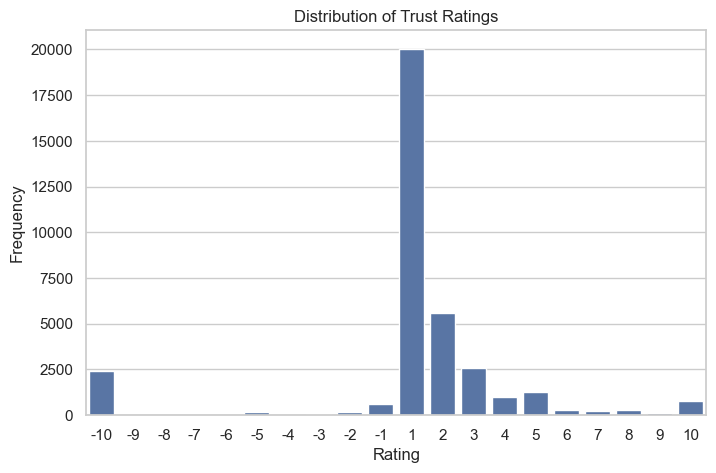

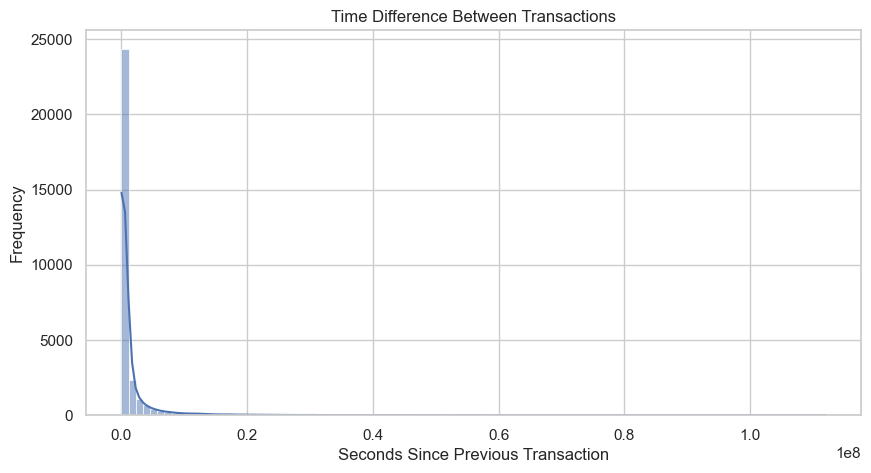

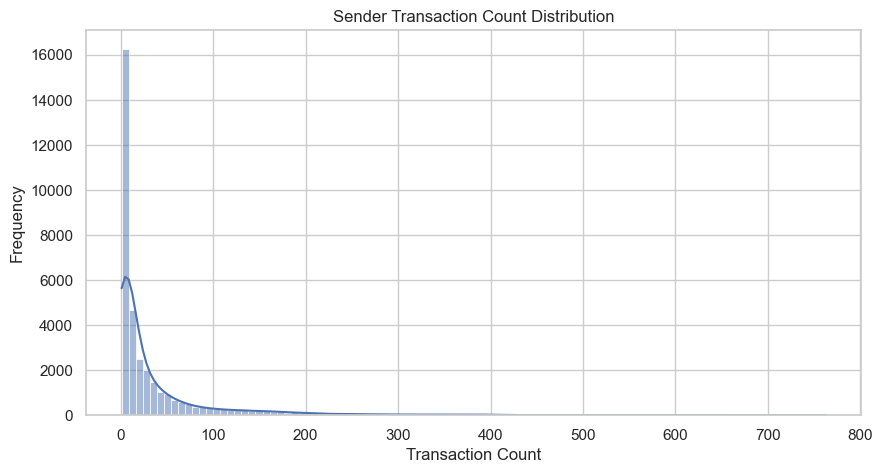

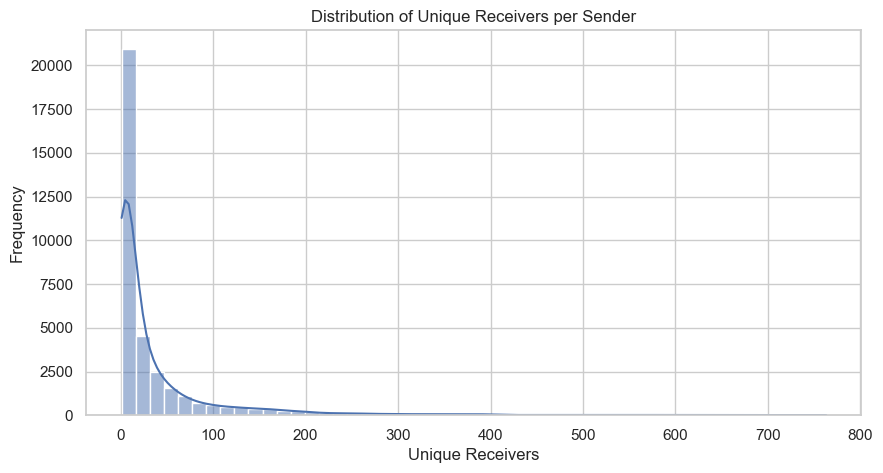

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the processed dataset
df = pd.read_csv("processed_bitcoinotc.csv")

# Convert datetime columns (they may be read as strings)
df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce')
df["prev_txn_time"] = pd.to_datetime(df["prev_txn_time"], errors='coerce')

# Seaborn style
sns.set(style="whitegrid")

# ----- 1. Trust Rating Distribution -----
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="rating")
plt.title("Distribution of Trust Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# ----- 2. Time Difference Between Transactions -----
# Clean 'time_diff_sec' for valid values only
df_cleaned = df[
    df['time_diff_sec'].notna() &
    np.isfinite(df['time_diff_sec']) &
    (df['time_diff_sec'] > 0)
]

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["time_diff_sec"], bins=100, kde=True)
plt.title("Time Difference Between Transactions")
plt.xlabel("Seconds Since Previous Transaction")
plt.ylabel("Frequency")
plt.show()

# ----- 3. Sender Transaction Count Distribution -----
plt.figure(figsize=(10, 5))
sns.histplot(df["sender_txn_count"], bins=100, kde=True)
plt.title("Sender Transaction Count Distribution")
plt.xlabel("Transaction Count")
plt.ylabel("Frequency")
plt.show()

# ----- 4. Unique Receivers per Sender -----
plt.figure(figsize=(10, 5))
sns.histplot(df["unique_receivers"], bins=50, kde=True)
plt.title("Distribution of Unique Receivers per Sender")
plt.xlabel("Unique Receivers")
plt.ylabel("Frequency")
plt.show()


In [6]:
#ML MODELS NEXT